In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import seaborn as sns

from tests.speedtest import generate_heatmap, generate_plots, run_test
from utils import get_cpu_name, get_files_from_array

In [2]:
display("CPU is {}".format(get_cpu_name()))
display("OpenCV version is {}".format(cv2.__version__))

'CPU is Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz'

'OpenCV version is 3.4.0'

In [3]:
dirs = ['bark', 'bikes', 'boat', 'graf', 'leuven', 'trees', 'ubc', 'wall']

cv2.ocl.setUseOpenCL(False)

files = get_files_from_array(dirs)
images = [cv2.imread(image, 0) for image in files]
data = run_test(images, True)

132 tests to run
.......... 10 
.......... 20 
.......... 30 
.......... 40 
.......... 50 
.......... 60 
.......... 70 
.......... 80 
.......... 90 
.......... 100 
.......... 110 
..
Done!


In [4]:
sns.reset_orig()
generate_plots(data)

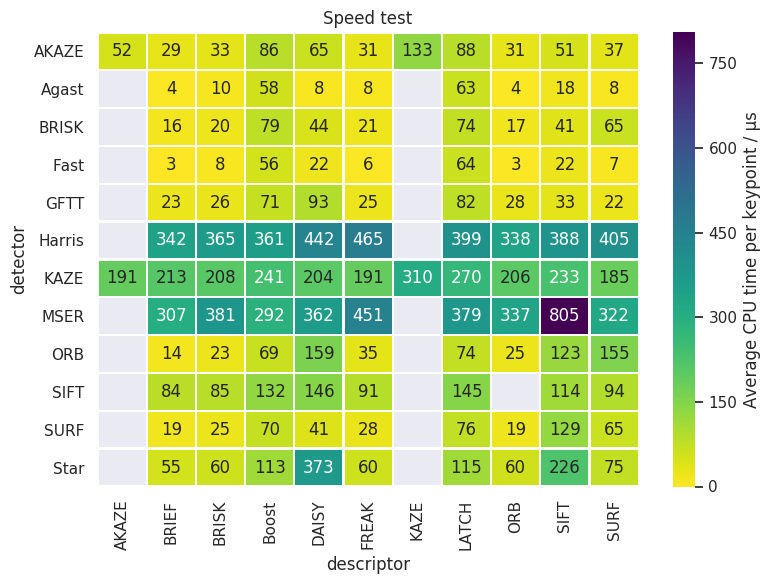

In [5]:
sns.set()
generate_heatmap(data)